In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('wordnet')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# We will visualize the messages with a word cloud
from wordcloud import WordCloud

# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Import the train test split
from sklearn.model_selection import train_test_split

# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dimik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dimik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Load the data
data = pd.read_csv('train.csv')

In [8]:
# Display firt five rows
display(data.head())

# Display the summary statistics
display(data.describe())

# Print the info
print(data.info())

,Unnamed: 0,title,text,subject,date,label
0,0,Obama’s Delusion Continues In Vapid Address To...,Obama addressed the Nation In a nothing burger...,politics,"Dec 6, 2015",0
1,1,Huge blast in China's Ningbo city kills at lea...,BEIJING (Reuters) - A powerful explosion in a ...,worldnews,"November 26, 2017",1
2,2,Trump applauds senators for new healthcare ref...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"September 13, 2017",1
3,3,UAW chief says Clinton told him she would rene...,(Reuters) - United Auto Workers President Denn...,politicsNews,"July 26, 2016",1
4,4,The Las Vegas Mass Shooting – More to the Stor...,Shawn Helton 21st Century WireAlthough many ar...,US_News,"October 12, 2017",0


,Unnamed: 0,label
count,100.000000,100.000000
mean,49.500000,0.540000
std,29.011492,0.500908
min,0.000000,0.000000
25%,24.750000,0.000000
50%,49.500000,1.000000
75%,74.250000,1.000000
max,99.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  100 non-null    int64 
 1   title       100 non-null    object
 2   text        100 non-null    object
 3   subject     100 non-null    object
 4   date        100 non-null    object
 5   label       100 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 4.8+ KB
None


label
0    555.391304
1    437.185185
Name: word_count, dtype: float64


C:\Users\dimik\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dimik\anaconda3\lib\site-packages\seaborn\distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\dimik\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\dimik\anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


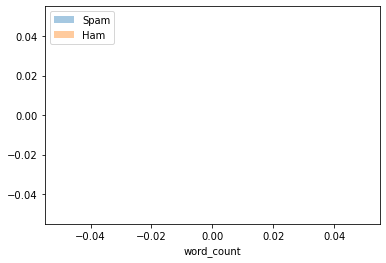

In [9]:
# Store the number of words in each messages
data['word_count'] = data['text'].str.split().str.len()

# Print the average number of words in each category
print(data.groupby('label')['word_count'].mean())

# Visualize the distribution of word counts in each category
sns.distplot(data[data['label']=='spam']['word_count'], label='Spam')
sns.distplot(data[data['label']=='ham']['word_count'], label='Ham'),
plt.legend()
plt.show()

In [12]:
# Make the letters lower case and tokenize the words
tokenized_texts = data['text'].str.lower().apply(word_tokenize)

# Print the tokens to see how it looks like
print(tokenized_texts)

0     [obama, addressed, the, nation, in, a, nothing...
1     [beijing, (, reuters, ), -, a, powerful, explo...
2     [washington, (, reuters, ), -, president, dona...
3     [(, reuters, ), -, united, auto, workers, pres...
4     [shawn, helton, 21st, century, wirealthough, m...
                            ...                        
95    [madrid, (, reuters, ), -, the, spanish, gover...
96    [the, election, result, tonight, is, hard, to,...
97    [if, what, we, say, reflects, on, how, our, pa...
98    [it, doesn, t, get, any, clearer, than, this, ...
99    [(, reuters, ), -, virginia, governor, terry, ...
Name: text, Length: 100, dtype: object


In [13]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(alpha)

print(tokenized_texts)

0     [obama, addressed, the, nation, in, a, nothing...
1     [beijing, reuters, a, powerful, explosion, in,...
2     [washington, reuters, president, donald, trump...
3     [reuters, united, auto, workers, president, de...
4     [shawn, helton, century, wirealthough, many, a...
                            ...                        
95    [madrid, reuters, the, spanish, government, ha...
96    [the, election, result, tonight, is, hard, to,...
97    [if, what, we, say, reflects, on, how, our, pa...
98    [it, doesn, t, get, any, clearer, than, this, ...
99    [reuters, virginia, governor, terry, mcauliffe...
Name: text, Length: 100, dtype: object


In [14]:
# Define a function to remove stop words
def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(remove_stop_words)

print(tokenized_texts)

0     [obama, addressed, nation, nothing, burger, ju...
1     [beijing, reuters, powerful, explosion, chines...
2     [washington, reuters, president, donald, trump...
3     [reuters, united, auto, workers, president, de...
4     [shawn, helton, century, wirealthough, many, s...
                            ...                        
95    [madrid, reuters, spanish, government, given, ...
96    [election, result, tonight, hard, swallow, man...
97    [say, reflects, parents, raised, us, bill, hil...
98    [get, clearer, iowa, steve, king, story, king,...
99    [reuters, virginia, governor, terry, mcauliffe...
Name: text, Length: 100, dtype: object


In [15]:
# Define a function to lemmatization
def lemmatize(tokens):
    """This function lemmatize the messages"""
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(lemmatize)

print(tokenized_texts)

0     obama addressed nation nothing burger jumble j...
1     beijing reuters powerful explosion chinese cit...
2     washington reuters president donald trump appl...
3     reuters united auto worker president dennis wi...
4     shawn helton century wirealthough many still s...
                            ...                        
95    madrid reuters spanish government given catala...
96    election result tonight hard swallow many u do...
97    say reflects parent raised u bill hillary clin...
98    get clearer iowa steve king story king introdu...
99    reuters virginia governor terry mcauliffe wedn...
Name: text, Length: 100, dtype: object


In [16]:
# Replace the columns with tokenized messages
data['text'] = tokenized_texts

# Display the first five rows
display(data.head())

,Unnamed: 0,title,text,subject,date,label,word_count
0,0,Obama’s Delusion Continues In Vapid Address To...,obama addressed nation nothing burger jumble j...,politics,"Dec 6, 2015",0,40
1,1,Huge blast in China's Ningbo city kills at lea...,beijing reuters powerful explosion chinese cit...,worldnews,"November 26, 2017",1,364
2,2,Trump applauds senators for new healthcare ref...,washington reuters president donald trump appl...,politicsNews,"September 13, 2017",1,82
3,3,UAW chief says Clinton told him she would rene...,reuters united auto worker president dennis wi...,politicsNews,"July 26, 2016",1,433
4,4,The Las Vegas Mass Shooting – More to the Stor...,shawn helton century wirealthough many still s...,US_News,"October 12, 2017",0,7928


In [17]:
# Select the features and the target
X = data['text']
y = data['label']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [19]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

In [20]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
print("Accuracy:",nb.score(tfidf_test, y_test))

Accuracy: 0.65


Confusion Matrix

[[ 2  7]
 [ 0 11]]


Classification Report

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.61      1.00      0.76        11

    accuracy                           0.65        20
   macro avg       0.81      0.61      0.56        20
weighted avg       0.79      0.65      0.58        20


ROC AUC Score: 0.6111111111111112


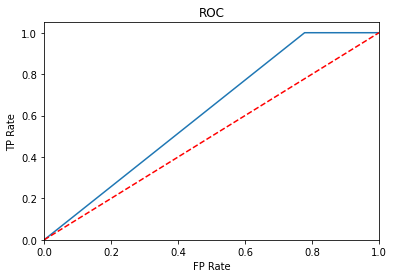

In [29]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)


# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:",auc_score)

# Get probabilities.
y_pred_proba = nb.predict(tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Visualize the ROC curve.
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.show()

https://www.kaggle.com/barishasdemir/classification-with-naive-bayes